# Project 3: Reddit API Classification & Natural Language Processing

## 03. EDA, Pre-Processing, Modeling & Conclusion

## Table of contents

- [1. Import Data and EDA](#1.-Import-Data-and-EDA)
- [2. Pre-Processing and Modeling](#2.-Pre-Processing-and-Modeling)
   - [2.1 Train Test Split](#2.1-Train-Test-Split)
   - [2.2 Pipeline CountVectorizer & Classifiers](#2.2-Pipeline-CountVectorizer-&-Classifiers)
   - [2.3 Pipeline TF-IDF & Classifiers](#2.3-Pipeline-TF-IDF-&-Classifiers)
   - [2.4 GridSearchCV](#2.4-GridSearchCV)
- [3. Evaluation and Conceptual Understanding](#3.-Evaluation-and-Conceptual-Understanding)
   - [3.1 Confusion Matrix](#3.1-Confusion-Matrix)
   - [3.2 Receiver Operating Characteristic (ROC) Curve & Area Under Curve (AUC)](#3.2-Receiver-Operating-Characteristic-(ROC)-Curve-&-Area-Under-Curve-(AUC))
   - [3.3 Missclassification](#3.3-Missclassification)
- [4. Conclusion and Recommendations](#4.-Conclusion-and-Recommendations)   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

%matplotlib inline
sns.set(font_scale = 1.25)

## 1. Import Data and EDA

In [2]:
py_df = pd.read_csv('../datasets/Python_cleaned.csv')
bd_df = pd.read_csv('../datasets/Bigdata_cleaned.csv')

In [3]:
py_df.shape

(866, 5)

In [4]:
bd_df.shape

(971, 5)

**Combine the Python and Bigdata post into a single DataFrame**

In [5]:
final_df = pd.concat([py_df,bd_df])

In [6]:
final_df.head()

,name,title,selftext,subreddit,title_text
0,t3_gdfaip,"/r/Python Job Board for May, June, July",Top Level comments must be **Job Opportunities...,Python,rpython job for may june july top level comm...
1,t3_gibxv4,What's everyone working on this week?,Tell /r/python what you're working on this wee...,Python,whats everyone working on this week tell rpyth...
2,t3_gl7lp7,Created a python script that execute Explorato...,NaN,Python,a python script that execute exploratory a...
3,t3_glikj1,I made an Android app that detects and recogni...,NaN,Python,i an app that recognises traffic signs...
4,t3_glikya,Anyone else learning python during the quarant...,I have been watching the lectures from a compu...,Python,anyone else learning python the quarantine i...


In [7]:
final_df.tail()

,name,title,selftext,subreddit,title_text
966,t3_djjg57,Big Data in Retail Industry [Case Studies] - T...,NaN,bigdata,big in retail take your business to nex...
967,t3_dji8zf,A Brief Introduction Of Big Data Framework,NaN,bigdata,a brief of big framework
968,t3_djcgf9,Simplifying the data pipeline,NaN,bigdata,simplifying the pipeline
969,t3_dj2vmp,Mainframe to Big Data - Why you should switch ...,NaN,bigdata,mainframe to big why you switch your care...
970,t3_dj66ew,Ideas for Big Data presentation,I don't know if this is the right place to ask...,bigdata,for big presentation i know if this is t...


In [8]:
final_df['subreddit'].value_counts()

bigdata    971
Python     866
Name: subreddit, dtype: int64

In [9]:
final_df['title_text'].sample(5)

852    how much        we generate every year  i reme...
19     help   for installing interpreter hello guys i...
495    i   an escape the room game entirely in python...
800    i am working on automatic image   using python...
336                               heap sort with python 
Name: title_text, dtype: object

In [10]:
#Define function to draw a word cloud

def draw_wordcloud(text, plot_title=None, mask_img=None):
    """
    Generate and draw word cloud from text.
    
    Parameters
    ----------
    text : str
        Text to generate word cloud from.
    title : str
        Title to set on plot
    mask_img: str
        Path to image mask
    """
    char_mask = np.array(Image.open(mask_img))
    image_colors = ImageColorGenerator(char_mask)
    
    wordcloud = WordCloud(
        mask = char_mask,
        scale=5,
        max_words=1000,
        background_color='white',
        colormap='brg',
        contour_width=3,
        contour_color='white',
        random_state=42
    ).generate(text)
    plt.figure(figsize=(10,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

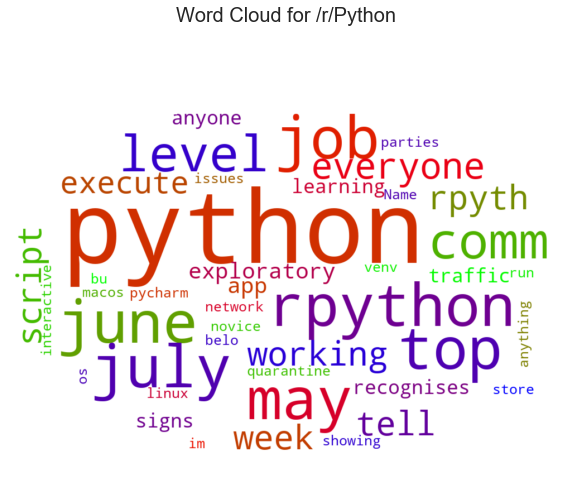

In [11]:
# Word cloud for /r/Python
draw_wordcloud(
    str(final_df[final_df['subreddit']=='Python'].title_text),
    plot_title = 'Word Cloud for /r/Python',
    mask_img = '../images/oval_mask.png'
)

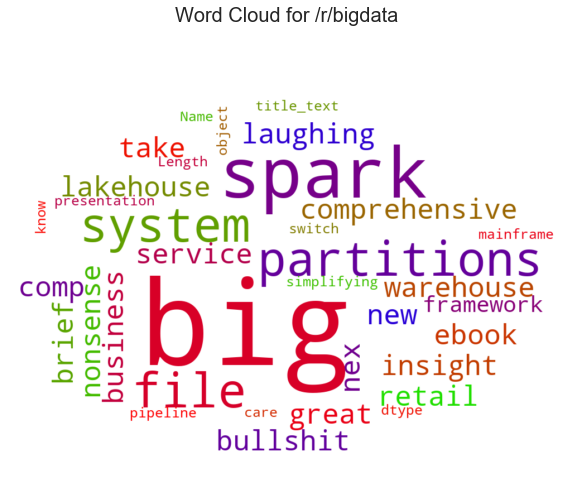

In [12]:
# Word cloud for /r/bigdata
draw_wordcloud(
    str(final_df[final_df['subreddit']=='bigdata'].title_text),
    plot_title = 'Word Cloud for /r/bigdata',
    mask_img = '../images/oval_mask.png'
)

In [13]:
len(final_df)

1837

In [14]:
# Instantiate CountVectorizer and TfidfVectorizer

cv = CountVectorizer(stop_words = frozenset(['english','python','big','data']))
tf = TfidfVectorizer(stop_words = frozenset(['english','python','big','data']))

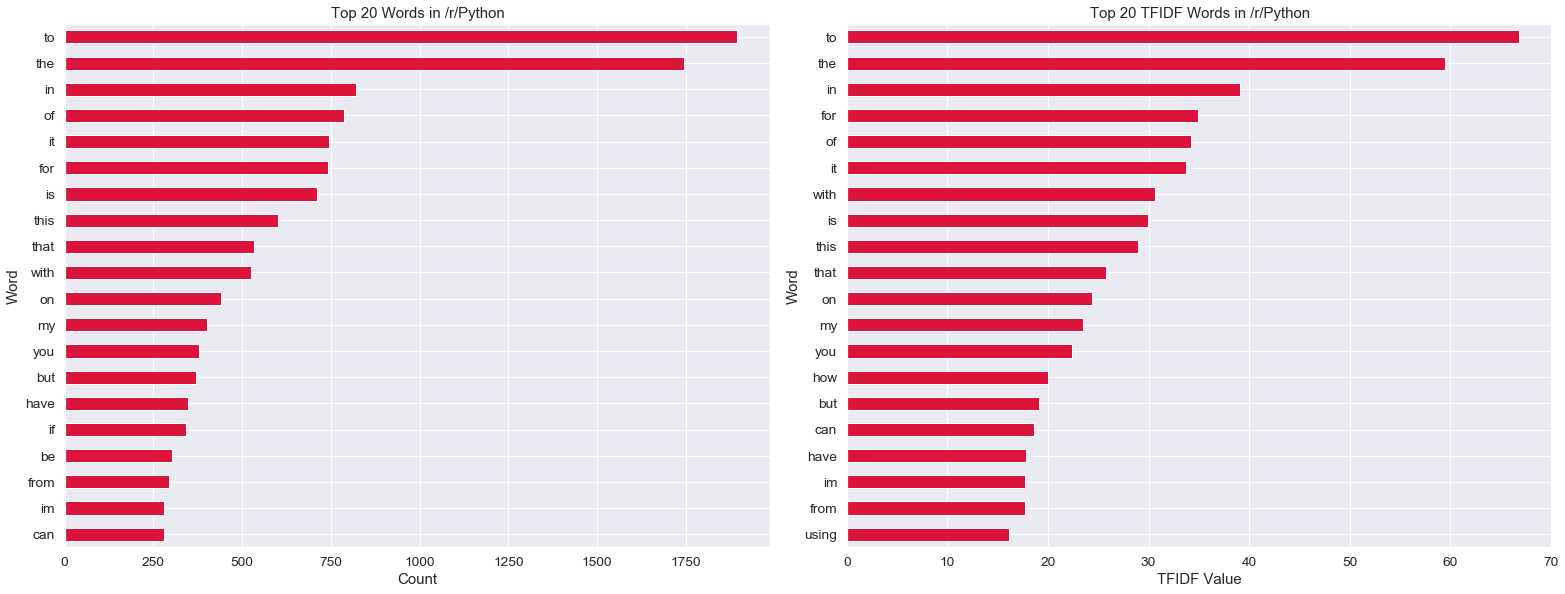

In [15]:
# Explore CountVectorizer word counts in /r/Python
words_cv_pf = pd.DataFrame(cv.fit_transform(final_df[final_df.subreddit=='Python'].title_text).todense(),
                       columns=cv.get_feature_names())
word_cv_counts_pf = words_cv_pf.sum(axis=0)

# Explore TfidfVectorizer word counts in /r/Python
words_tf_pf = pd.DataFrame(tf.fit_transform(final_df[final_df.subreddit=='Python'].title_text).todense(),
                       columns=tf.get_feature_names())
word_counts_tf_pf = words_tf_pf.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white',)

plt.subplot(2,2,1)
word_cv_counts_pf.sort_values().tail(20).plot(kind='barh', color = 'crimson')
plt.title('Top 20 Words in /r/Python')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tf_pf.sort_values().tail(20).plot(kind='barh',color = 'crimson')
plt.title('Top 20 TFIDF Words in /r/Python')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

>The bar chart above shows which words occured most frequent in the r/Python subreddits, and comparing both TFIDF and CountVectorizer model, the results are quite similar.

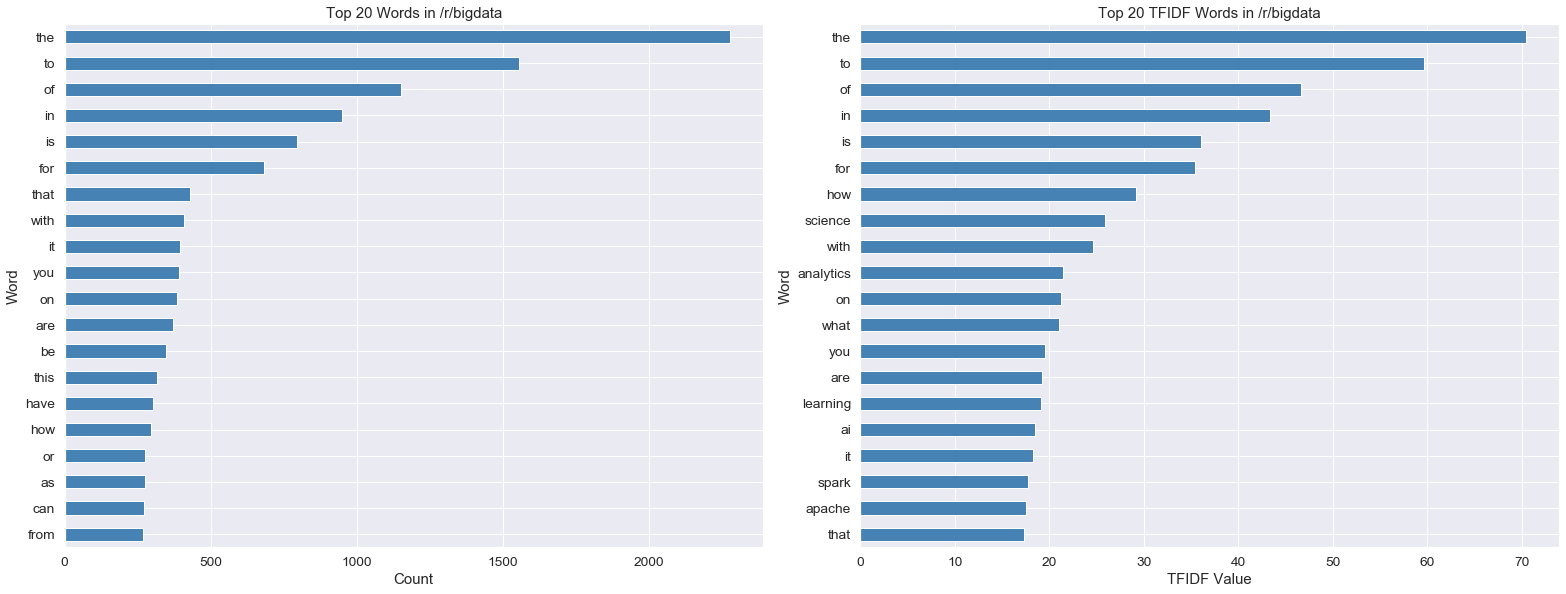

In [16]:
# Explore CountVectorizer word counts in /r/bigdata
words_cv_pf = pd.DataFrame(cv.fit_transform(final_df[final_df.subreddit=='bigdata'].title_text).todense(),
                       columns=cv.get_feature_names())
word_cv_counts_pf = words_cv_pf.sum(axis=0)

# Explore TfidfVectorizer word counts in /r/bigdata
words_tf_pf = pd.DataFrame(tf.fit_transform(final_df[final_df.subreddit=='bigdata'].title_text).todense(),
                       columns=tf.get_feature_names())
word_counts_tf_pf = words_tf_pf.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white',)

plt.subplot(2,2,1)
word_cv_counts_pf.sort_values().tail(20).plot(kind='barh', color = 'steelblue')
plt.title('Top 20 Words in /r/bigdata')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tf_pf.sort_values().tail(20).plot(kind='barh',color = 'steelblue')
plt.title('Top 20 TFIDF Words in /r/bigdata')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

>The bar chart above shows which words occured most frequent in the r/bigdata subreddits, by compating TFIDF and CountVectorizer model, both word counts are quite similar.

## 2. Pre-Processing and Modeling

In [17]:
# Binarize the subreddit, /r/Python as 0 and /r/bigdata as 1
final_df['subreddit'] = [1 if i =='bigdata' else 0 for i in final_df['subreddit']] 

In [18]:
final_df

,name,title,selftext,subreddit,title_text
0,t3_gdfaip,"/r/Python Job Board for May, June, July",Top Level comments must be **Job Opportunities...,0,rpython job for may june july top level comm...
1,t3_gibxv4,What's everyone working on this week?,Tell /r/python what you're working on this wee...,0,whats everyone working on this week tell rpyth...
2,t3_gl7lp7,Created a python script that execute Explorato...,NaN,0,a python script that execute exploratory a...
3,t3_glikj1,I made an Android app that detects and recogni...,NaN,0,i an app that recognises traffic signs...
4,t3_glikya,Anyone else learning python during the quarant...,I have been watching the lectures from a compu...,0,anyone else learning python the quarantine i...
...,...,...,...,...,...
966,t3_djjg57,Big Data in Retail Industry [Case Studies] - T...,NaN,1,big in retail take your business to nex...
967,t3_dji8zf,A Brief Introduction Of Big Data Framework,NaN,1,a brief of big framework
968,t3_djcgf9,Simplifying the data pipeline,NaN,1,simplifying the pipeline
969,t3_dj2vmp,Mainframe to Big Data - Why you should switch ...,NaN,1,mainframe to big why you switch your care...


In [19]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837 entries, 0 to 970
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1837 non-null   object
 1   title       1837 non-null   object
 2   selftext    841 non-null    object
 3   subreddit   1837 non-null   int64 
 4   title_text  1837 non-null   object
dtypes: int64(1), object(4)
memory usage: 86.1+ KB


In [20]:
#Check if there is any null value after combine /r/Python and /r/bigdata
final_df.isnull().sum()

name            0
title           0
selftext      996
subreddit       0
title_text      0
dtype: int64

In [21]:
final_df.fillna(value = ' ', axis = 1, inplace = True)

In [22]:
final_df['title_text'].astype(str)

0      rpython job   for may june july top level comm...
1      whats everyone working on this week tell rpyth...
2        a python script that execute exploratory   a...
3      i   an   app that     recognises traffic signs...
4      anyone else learning python   the quarantine i...
                             ...                        
966    big   in retail      take your business to nex...
967                        a brief   of big   framework 
968                          simplifying the   pipeline 
969    mainframe to big    why you   switch your care...
970      for big   presentation i   know if this is t...
Name: title_text, Length: 1837, dtype: object

### 2.1 Train Test Split

In [23]:
X = final_df['title_text']
y = final_df['subreddit']

In [24]:
final_df['title_text']

0      rpython job   for may june july top level comm...
1      whats everyone working on this week tell rpyth...
2        a python script that execute exploratory   a...
3      i   an   app that     recognises traffic signs...
4      anyone else learning python   the quarantine i...
                             ...                        
966    big   in retail      take your business to nex...
967                        a brief   of big   framework 
968                          simplifying the   pipeline 
969    mainframe to big    why you   switch your care...
970      for big   presentation i   know if this is t...
Name: title_text, Length: 1837, dtype: object

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size = 0.2)

**Check each data set len**

In [26]:
print ("X train : " , len(X_train))
print ("X test : " , len(X_test))
print ("Y train : " , len(y_train))
print ("Y test : " , len(y_test))

X train :  1469
X test :  368
Y train :  1469
Y test :  368


**Baseline Accuracy**

We need to know what is the baseline accuracy value in order to tell if the model built is better than the null model.

In [27]:
y_test.value_counts(normalize = True)

1    0.529891
0    0.470109
Name: subreddit, dtype: float64

### 2.2 Pipeline CountVectorizer & Classifiers

By using Pipeline to fit the Countvectorizer with classifiers to get the benchmark score, can compare the train test score whether the data is overfitted or undderfitted.

The CountVectorizer model will be run with following 4 classifiers:

- Logistic Regression
- Multinomial Naive Bayes
- Random Forest
- Decision Tree Classifier

**CountVectorizer and model of LogisticRegression**

In [28]:
# Define the pipeline sequence, model and parameters
cv_lr =  [('cv',CountVectorizer(stop_words = frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('lr',LogisticRegressionCV(solver = 'lbfgs',random_state = 42, cv =5, max_iter=300))]
# Instantiate Pipeline
pipe_lr = Pipeline(cv_lr)

In [29]:
#instantiate CounVectorizer
cv = CountVectorizer(stop_words = frozenset(['english','python','big','data']))

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

print("Total Features: {}".format(len(cv.get_feature_names())))

Total Features: 6699


In [30]:
print("Cvec Logistic Regression Model")

pipe_lr.fit(X_train, y_train)
train_score_lr = pipe_lr.score(X_train, y_train)
test_score_lr = pipe_lr.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_lr,4),round(test_score_lr,4)))

Cvec Logistic Regression Model


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train score: 0.9653 
 Test score 0.8234


>Train score is much higher than the test score,so the model is overfitted.

**CountVectorizer and model of Naive Bayes**

In [31]:
# Define the pipeline sequence, model and parameters
mn_nb =  [('cv',CountVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('mnb',MultinomialNB())]

# Instantiate Pipeline
pipe_nb = Pipeline(mn_nb)

In [32]:
print("Cvec Naive Bayes Model")

pipe_nb.fit(X_train, y_train)
train_score_nb = pipe_nb.score(X_train, y_train)
test_score_nb = pipe_nb.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_nb,4), round(test_score_nb,4)))

Cvec Naive Bayes Model
Train score: 0.9176 
 Test score 0.8234


>The train score decreased comparing to the baseline Logistic Regression model, however the train score is still higher than the test score, the model is still overfit.

**CountVectorizer and RandomForestClassifier model**

In [33]:
# Define the pipeline sequence, model and parameters
cv_rf =  [('cv',CountVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('rf',RandomForestClassifier())]
# Instantiate Pipeline
pipe_rf = Pipeline(cv_rf)

In [34]:
print("Cvec Random Forest Classifier")

pipe_rf.fit(X_train, y_train)
train_score_rf = pipe_rf.score(X_train, y_train)
test_score_rf = pipe_rf.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_rf,4), round(test_score_rf,4)))

Cvec Random Forest Classifier
Train score: 0.9966 
 Test score 0.7582


>The train score is much higher than test score, this show the model is not performing better than previous 2 models, the model is still overfit.

**CountVectorizer and DecisionTreeClassifier model**

In [35]:
# Define the pipeline sequence, model and parameters
cv_tree =  [('cv',CountVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('tree',DecisionTreeClassifier())]
# Instantiate Pipeline
pipe_tree = Pipeline(cv_tree)

In [36]:
print("Cvec Decision Tree Classifier")

pipe_tree.fit(X_train, y_train)
train_score_tree = pipe_tree.score(X_train, y_train)
test_score_tree = pipe_tree.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_tree,4), round(test_score_tree,4)))

Cvec Decision Tree Classifier
Train score: 0.9966 
 Test score 0.7201


>Similar to Random Forest Classifier the train score is much higher than test score, and notably it is the worst among the 4 models chose ,and the model is overfit too.

### 2.3 Pipeline TF-IDF & Classifiers

By using Pipeline to fit the TF-IDF with classfiers to get the benchmark score, can compare the train test score whether the data is overfitted or undderfitted.

The TF-IDF model will be run with following 4 classifiers:

- Logistic Regression
- Multinomial Naive Bayes
- Random Forest
- Decision Tree Classifier

**TF-IDF and model of LogisticRegression**

In [37]:
tf_lr = [('tf',TfidfVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('lr',LogisticRegressionCV(solver = 'lbfgs',random_state = 42, cv =5,max_iter=300))]

# Instantiate Pipeline
pipe_tf_lr = Pipeline(tf_lr)

In [38]:
print("TF-IDF Logistic Regression Model")

pipe_tf_lr.fit(X_train, y_train)
train_score_tf_lr = pipe_tf_lr.score(X_train, y_train)
test_score_tf_lr = pipe_tf_lr.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_tf_lr,4),round(test_score_tf_lr,4)))

TF-IDF Logistic Regression Model
Train score: 0.9673 
 Test score 0.8533


>Comparing with CountVectorizer with Logistic Regression model, the train score slightly improve 0.1, and the test score remain the same, the model is still overfit.

**TF-IDF and model of Naive Bayes**

In [39]:
# Define the pipeline sequence, model and parameters
tf_nb =  [('tf',TfidfVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('mnb',MultinomialNB())]

# Instantiate Pipeline
pipe_tf_nb = Pipeline(tf_nb)

In [40]:
print("TF-IDF Naive Bayes Model")

pipe_tf_nb.fit(X_train, y_train)
train_score_tf_nb = pipe_tf_nb.score(X_train, y_train)
test_score_tf_nb = pipe_tf_nb.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_tf_nb,4), round(test_score_tf_nb,4)))

TF-IDF Naive Bayes Model
Train score: 0.9408 
 Test score 0.8342


>The train score increased comparing to the CountVectorizer with Logistic Regression model and model is overfit.

**TF-IDF and RandomForestClassifier model**

In [41]:
# Define the pipeline sequence, model and parameters
tf_rf =  [('tf',TfidfVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('rf',RandomForestClassifier())]
# Instantiate Pipeline
pipe_tf_rf = Pipeline(tf_rf)

In [42]:
print("TF-IDF Random Forest Classifier")

pipe_tf_rf.fit(X_train, y_train)
train_score_tf_rf = pipe_tf_rf.score(X_train, y_train)
test_score_tf_rf = pipe_tf_rf.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_tf_rf,4), round(test_score_tf_rf,4)))

TF-IDF Random Forest Classifier
Train score: 0.9966 
 Test score 0.7663


>The train score remain the same comparing with CountVectorizer, but there is a slight drop for test score and model is overfit.

**TF-IDF and DecisionTreeClassifier model**

In [43]:
# Define the pipeline sequence, model and parameters
tf_tree =  [('tf',TfidfVectorizer(stop_words=frozenset(['english','python','big','data']), ngram_range=(1,2), max_features = 5_000)),
            ('tree',DecisionTreeClassifier())]
# Instantiate Pipeline
pipe_tf_tree = Pipeline(tf_tree)

In [44]:
print("TF-IDF Decision Tree Classifier")

pipe_tf_tree.fit(X_train, y_train)
train_score_tf_tree = pipe_tf_tree.score(X_train, y_train)
test_score_tf_tree = pipe_tf_tree.score(X_test, y_test)

print("Train score: {} \n Test score {}".format(round(train_score_tf_tree,4), round(test_score_tf_tree,4)))

TF-IDF Decision Tree Classifier
Train score: 0.9966 
 Test score 0.6957


>Similar to TF-IDF Random Forest Classifier the train score remain the same comparing with CountVectorizer, but the test score had drop more and hence the worst performed model among the all models.

### 2.4 GridSearchCV

All the benchmark models aboves were overfitted, so in order to improve the test score, we will run GridSearchCV to program multiple hyperparameters to tune the model to generate the better scoring with different combinations.

In [45]:
# Create dictionary for models
model_dict = {
    'cv': CountVectorizer(stop_words=frozenset(['english','python','big','data'])),
    'tf': TfidfVectorizer(stop_words=frozenset(['english','python','big','data'])),
    'lr': LogisticRegressionCV(solver='lbfgs', random_state =42, cv=5,max_iter=500),
    'nb': MultinomialNB(),
    'tree': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [46]:
model_lib = {
    'cv': 'CountVectorizer',
    'tf': 'TfidfVectorizer',
    'lr': 'Logistic Regression',
    'nb': 'Multinomial NB',
    'rf': 'Random Forest',
    'tree': 'Decision Tree'
}

In [47]:
# Create dictionary for each model and classifier hyperparameters

model_params ={
    'cv': {
        'cv__max_features': [2500, 5000],
        'cv__min_df': [2, 3],
        'cv__max_df': [.9, .95],
        'cv__ngram_range': [(1,1), (1,2)]
    },
    'tf': {
        'tf__max_features': [2500, 5000],
        'tf__min_df': [2, 3],
        'tf__max_df': [.9, .95],
        'tf__ngram_range': [(1,1), (1,2)]
    },
    'lr': {},
    'nb': {},
    'rf': {},
    'tree': {}
}

In [48]:
# Define pipeline of models
def pipelines (models_list):
    
    pipe_model = [(i,model_dict[i]) for i in models_list]
    return Pipeline(pipe_model)

In [49]:
# Define parameters to fit into GridSearch
def parameter(name,model_dict):
    parameters = model_params[name]
    for k,v in parameters.items():
        model_dict[k] = v
    return model_dict

In [50]:
# Define GridSearch
def gs(method,model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    pipe_param = {}
    pipe_param = parameter(method,pipe_param)
    pipe_param = parameter(model,pipe_param)
    pipe = pipelines([method,model])
    g_search = GridSearchCV(pipe,param_grid=pipe_param, cv =5)
    g_search.fit(X_train,y_train)
    print(f'{model_lib[model]} with {model_lib[method]}:')
    print(f'Train Score : {round(g_search.best_estimator_.score(X_train,y_train),4)}')
    print(f'Test Score: {round(g_search.best_estimator_.score(X_test,y_test),4)}')
    print(f'Parameters: {g_search.best_params_}')
    return g_search.best_estimator_.predict(X_test)

**GridSearch of CountVectorizer**

In [51]:
cv_lr_pred = gs('cv', 'lr')

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Logistic Regression with CountVectorizer:
Train Score : 0.9605
Test Score: 0.8207
Parameters: {'cv__max_df': 0.9, 'cv__max_features': 2500, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [52]:
cv_nb_pred = gs('cv', 'nb')

Multinomial NB with CountVectorizer:
Train Score : 0.9142
Test Score: 0.8315
Parameters: {'cv__max_df': 0.9, 'cv__max_features': 2500, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}


In [53]:
cv_rf_pred = gs('cv', 'rf')

Random Forest with CountVectorizer:
Train Score : 0.9973
Test Score: 0.7826
Parameters: {'cv__max_df': 0.95, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}


In [54]:
cv_tree_pred = gs('cv', 'tree')

Decision Tree with CountVectorizer:
Train Score : 0.9966
Test Score: 0.7337
Parameters: {'cv__max_df': 0.95, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2)}


>Comparing the results for the 4 models above, the CountVectorize with Multinomial Naive Bayes perform the best among the 4 models. Next we try to compare the scoring with GridSearch of TF-IDF models.

**GridSearch of TF-IDF**

In [55]:
tf_lr_pred = gs('tf', 'lr')

Logistic Regression with TfidfVectorizer:
Train Score : 0.9694
Test Score: 0.8478
Parameters: {'tf__max_df': 0.9, 'tf__max_features': 5000, 'tf__min_df': 3, 'tf__ngram_range': (1, 2)}


In [56]:
tf_nb_pred = gs('tf', 'nb')

Multinomial NB with TfidfVectorizer:
Train Score : 0.9258
Test Score: 0.8505
Parameters: {'tf__max_df': 0.9, 'tf__max_features': 2500, 'tf__min_df': 3, 'tf__ngram_range': (1, 1)}


In [57]:
tf_rf_pred = gs('tf', 'rf')

Random Forest with TfidfVectorizer:
Train Score : 0.9966
Test Score: 0.7663
Parameters: {'tf__max_df': 0.9, 'tf__max_features': 2500, 'tf__min_df': 3, 'tf__ngram_range': (1, 1)}


In [58]:
tf_tree_pred = gs('tf', 'tree')

Decision Tree with TfidfVectorizer:
Train Score : 0.9966
Test Score: 0.6902
Parameters: {'tf__max_df': 0.95, 'tf__max_features': 5000, 'tf__min_df': 3, 'tf__ngram_range': (1, 2)}


>After comparing 4 TF-IDF models above with the Countvectorizer models, the scorings are similar that the NaiveBayes classfier scored better. In the conclusion, the CountVectorizer and TF-IDF with Multinomial Naive Bayes Classifier as the best model among the 8 models, so we will chose 1 of the model for next evaluation.

## 3. Evaluation and Conceptual Understanding

In this case, I will chose CountVectorizer with Multinomial Naive Bayes Classifier for evaluation because comparing to the TF-IDF model the scoring are quite similar.

In [59]:
print(classification_report(y_test, cv_nb_pred, target_names=['r/Python','r/bigdata']))

              precision    recall  f1-score   support

    r/Python       0.81      0.84      0.82       173
   r/bigdata       0.85      0.83      0.84       195

    accuracy                           0.83       368
   macro avg       0.83      0.83      0.83       368
weighted avg       0.83      0.83      0.83       368



**Comparing with TF-IDF with Multinomial NaiveBayes Classification**

In [60]:
print(classification_report(y_test, tf_nb_pred, target_names=['r/Python','r/bigdata']))

              precision    recall  f1-score   support

    r/Python       0.83      0.86      0.84       173
   r/bigdata       0.87      0.85      0.86       195

    accuracy                           0.85       368
   macro avg       0.85      0.85      0.85       368
weighted avg       0.85      0.85      0.85       368



>The classifications report of Multinomial Naive Bayes Classifier ,so we proceed with TF-IDF with Multinomial NaiveBayes Classifier as our model.

### 3.1 Confusion Matrix

In [80]:
cm = confusion_matrix(y_test, tf_nb_pred)
cm

array([[148,  25],
       [ 30, 165]], dtype=int64)

In [81]:
cm_df = pd.DataFrame(cm, columns=['pred r/Python', 'pred r/bigdata'], index=['actual r/Python', 'actual r/bigdata'])
cm_df

,pred r/Python,pred r/bigdata
actual r/Python,148,25
actual r/bigdata,30,165


In [82]:
tn, fp, fn, tp = confusion_matrix(y_test, tf_nb_pred).ravel()
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 148

False Positives: 25

False Negatives: 30

True Positives: 165


In [83]:
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8505
Misclassification rate: 0.1495
Precision: 0.8684
Recall: 0.8462
Specificity: 0.8555


### 3.2 Receiver Operating Characteristic (ROC) Curve & Area Under Curve (AUC)

In [84]:
nb = MultinomialNB()
tf = TfidfVectorizer(stop_words=frozenset(['english','python','big','data']))

In [85]:
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

nb.fit(X_train_tf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [86]:
nb.predict_proba(X_test_cv)[:5]
pred_proba = [i[1] for i in nb.predict_proba(X_test_tf)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [87]:
pred_df.head()

,true_values,pred_probs
224,1,0.282474
330,0,0.107090
731,1,0.636542
378,1,0.544048
458,0,0.059750


In [88]:
#get the roc_auc_score
roc_auc= roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])
roc_auc

0.9296576256113829

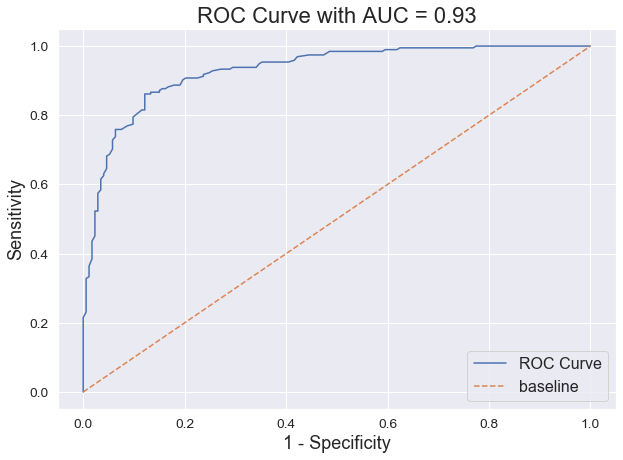

In [89]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## 3.3 Missclassification

In [90]:
# Examine incorrectly classified posts
y_pred = cv_nb_pred
df_pred = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'y_pred': y_pred
})

# Posts incorrectly predicted to be in /r/Python
for i in df_pred[(df_pred.y_test - df_pred.y_pred) == -1]['X_test']:
    print(i)
    print('-'*20)

  install    a popular python   on   
--------------------
pipenv v      b   first release in over   years 
--------------------
input   output in python    school 
--------------------
realtime vehicle   with opencv in    minutes 
--------------------
python   python     is now available 
--------------------
i wrote a new ui framework   by flutter 
--------------------
python release python    rc  
--------------------
python community interview with christopher bailey – real python 
--------------------
python   survey      results 
--------------------
our journey to type checking   million lines of python 
--------------------
python x lotf 
--------------------
online course   can anyone   an online courseprofessional certification in   analytics using python im   in learning   analytics tools for lean management   any   is much    pm
--------------------
heap      structures  algorithmpython   
--------------------
    rgbw strips 
--------------------
for anyone trying to   the

In [91]:

# Explore /r/bigdata posts that are incorrectly predicted to /r/Python
for i in df_pred[(df_pred.y_test - df_pred.y_pred) == 1]['X_test']:
    print(i)
    print('-'*150)

best “     ” tools free hey everyone i’m currently using   to mine analyse   visualise   i’m quite   with it but i was   if there’s better free softwares tools than this one which  ’t   any programming   to operate   so any suggestions   be great help thanks
------------------------------------------------------------------------------------------------------------------------------------------------------
  is making its online ai crash course free to the   
------------------------------------------------------------------------------------------------------------------------------------------------------
is it possible to execute queries to   fusing vba   if so how  thank you
------------------------------------------------------------------------------------------------------------------------------------------------------
an open source stack   version control   cortex for managing        stepbystep tutorial 
------------------------------------------------------------------------

>Refering to both sets of data of the wrong predicted data, the reason that the posts might be missclassified were due to:
1. The user might post in the subrredit topic in either one of subreddit, this will happen because both Python and Bigdata subreddit were related topics.
2. The post is related to both topics, so the post can be classified in either subreddit.

## 4. Conclusion and Recommendations

The Multinomial Naive Bayes with Countvectorizer perform well with accuracy score at 85%, even though both subreddits were related.
This project can be further improve by expand the scopes to include following steps:
- Collect more subreddits post from both subreddits topics
- Not to drop duplicates of the same user id, drop the similar post instead
- Tuning the parameters of each model to acheive better scores, however this will required a long amount of time for computer to tune and compile the best parameters.
- Consider others classifiers such as Adaboost, Gradientboost, etc.
- Stop word to reduce to only 'english', even thought the title of the subreddit will the the word which occur most frequent in the end to lower the overfit of the data.